# Initialize table and data from file

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# plot table
import texttable as tt

def plotTable(headers,
              rows,
              valign=True,
              column_width=False,
              no_deco=False,
              precision=1):
    tab = tt.Texttable()
    if len(headers) > 0:
        tab.header(headers)
    tab.set_precision(precision)
    for row in rows:
        tab.add_row(row)

    if valign and len(headers) > 0:
        tab.set_cols_valign(['m'] * len(headers))

    if column_width:
        columns = [0] * len(rows[0])
        for row in rows:
            for i, cell in enumerate(row):
                if isinstance(row[i], str):
                    columns[i] = max(
                        columns[i],
                        max([len(line) for line in row[i].split('\n')]))
        for i, head in enumerate(headers):
            columns[i] = max(columns[i], len(head))
        tab.set_cols_width(columns)

    if no_deco:
        tab.set_deco(tt.Texttable.HEADER | tt.Texttable.VLINES)

    s = tab.draw()
    return s

def data_from_file(file_name,case):
    #case = 1-> Id from file. Iq in 0->220 > 'i_direct_flux'
    #case = 2 -> Iq from file. Id in 0->220 > 'j_q_flux'
    data = np.loadtxt(file_name)
    ids = data[0, :]    
    dfs = data[1:, :]
    iqs = list(range(220, -1, -20))
    if case == 1:
        xLabel = 'Id'
        yLabel = 'direct flux'
        Is = 'Iq'
    elif case == 2:
        xLabel = 'Iq'
        yLabel = 'quadratic flux'  
        Is = 'Id'
    return ids, dfs, iqs, xLabel, yLabel, Is


ids, dfs, iqs, xLabel, yLabel, Is = data_from_file('i_direct_flux', 1)

# Plot all Iqs curves

In [ ]:
plt.rcParams["figure.figsize"] = [12, 8]

for idx in range(0, 12):
    df = dfs[:, idx]
    plt.plot(ids, df, label='Iq = %d' %iqs[idx])
    plt.ylim([0, 0.25])
    plt.xlim([0, 220])
    plt.xticks(ids)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.legend(loc='best')
plt.grid()
plt.show()

# Cubic spline interpolation

Iq: 200, pts num: 6


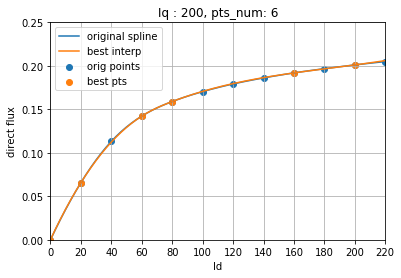

Iq: 200, pts num: 5


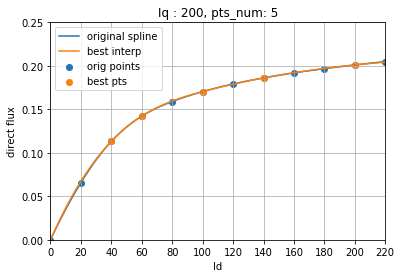

Iq: 200, pts num: 4


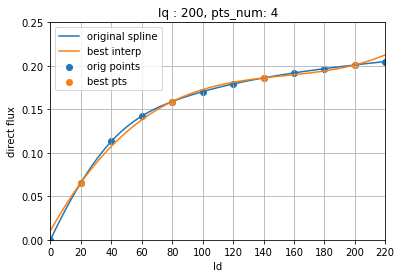

Iq: 160, pts num: 6


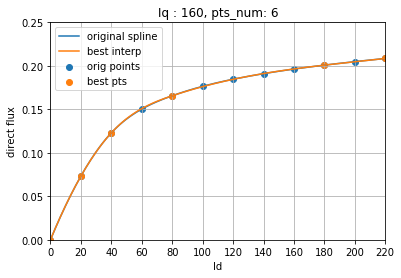

Iq: 160, pts num: 5


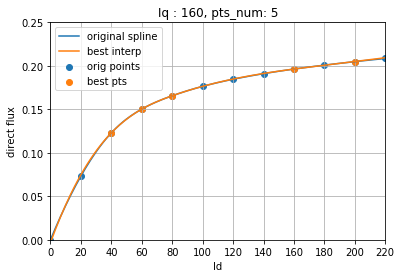

Iq: 160, pts num: 4


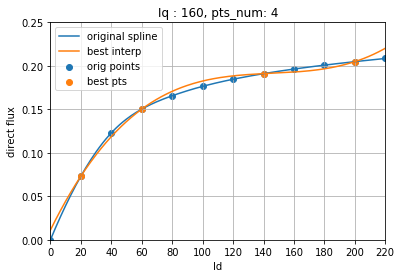

Iq: 120, pts num: 6


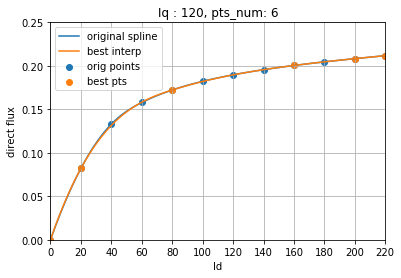

Iq: 120, pts num: 5


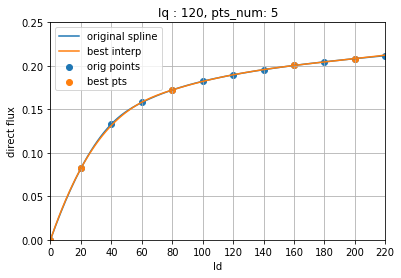

Iq: 120, pts num: 4


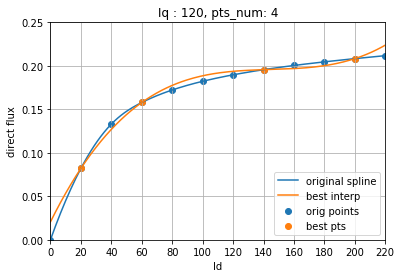

Iq: 80, pts num: 6


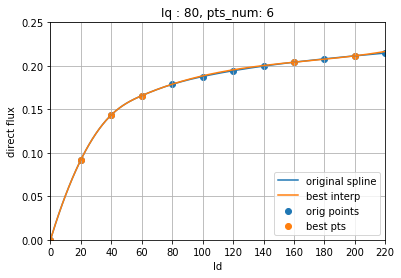

Iq: 80, pts num: 5


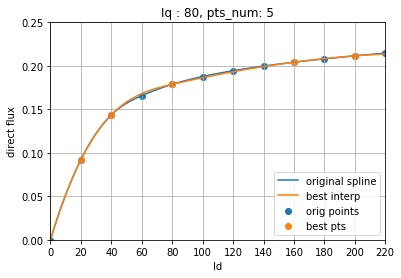

Iq: 80, pts num: 4


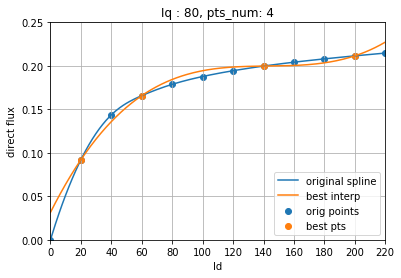

Iq: 40, pts num: 6


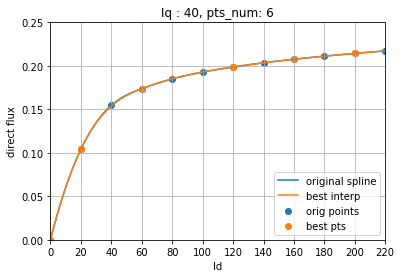

Iq: 40, pts num: 5


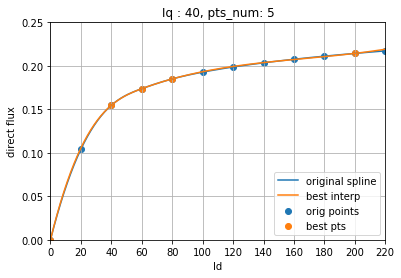

Iq: 40, pts num: 4


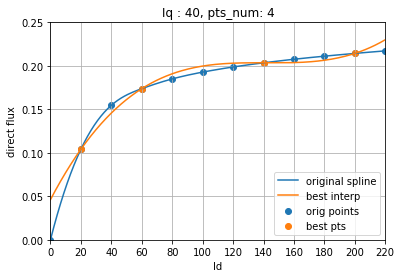

Iq: 0, pts num: 6


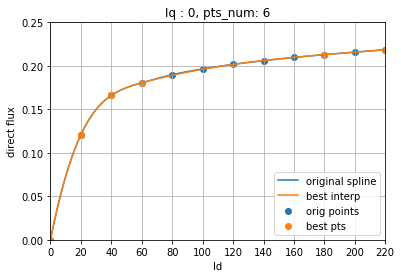

Iq: 0, pts num: 5


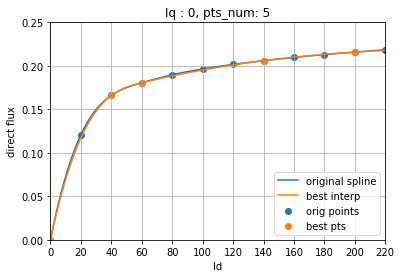

Iq: 0, pts num: 4


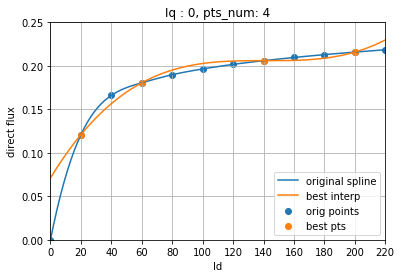

Interpolation error ( sum squared error * 10 ^ 6)
+--------+-------------+-------------+------------+------------+------------+------------+------------+------------+--------------------------------+
|   Iq   | pts num: 11 | pts num: 10 | pts num: 9 | pts num: 8 | pts num: 7 | pts num: 6 | pts num: 5 | pts num: 4 |  ######### 5_best_pts ######## |
+========+=============+=============+============+============+============+============+============+============+================================+
| Iq 220 | 0.00012     | 0.00015     | 0.00024    | 0.00039    | 0.00442    | 0.05731    | 0.95977    | 13.82680   | [ 40.  60. 100. 180. 200.]     |
+--------+-------------+-------------+------------+------------+------------+------------+------------+------------+--------------------------------+
| Iq 200 | 0.00001     | 0.00008     | 0.00008    | 0.00035    | 0.00203    | 0.19464    | 0.34677    | 20.11968   | [ 40.  60. 100. 140. 200.]     |
+--------+-------------+-------------+------------

In [4]:
#cubic spline interpolation

from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys

ids, dfs, iqs, xLabel, yLabel, Is = data_from_file('i_direct_flux', 1)

def sum_squared_error(gr, pred):
    gr = np.array(gr)
    pred = np.array(pred)
    return (10 ** 6) * (1 / gr.shape[0]) * sum((gr - pred) ** 2)

curve_indices = list(range(0, 12)) 
curves_for_plot = list(range(1, 13,2))
pts_for_plot = [6,5,4]

# try interpolating with only 10, 9, 8 ... 4, 3 points
sub_points_num  = list(range(len(ids)-1, 3, -1))

headers = ['%s' %Is] + ['pts num: %d' % pts for pts in sub_points_num] + [' ######### 5_best_pts ########']
rows = []
x_best_5_pts = []
y_best_5_pts = []

for curve in curve_indices: #pentru fiecare curba Iq
    y = dfs[:, curve] #iau fluxurile corespunzatoare
    x = ids #iau id-urile
        
    tck = interpolate.splrep(x, y, s=0) #face spline pe toate cele 12 puncte
    x_new = np.linspace(min(x), max(x), 200)
        
    # baseline = y values obtained when interpolating with all ground truth points
    baseline = interpolate.splev(x_new, tck, der=0)
    
    row = ['%s %d' % (Is, iqs[curve])]
    best_5_points =[]
   
    for points_num in sub_points_num:
        # store best configuration
        best_pts     = (x, y)
        best_interp  = (x_new, baseline)
        best_error   = sys.float_info.max
        best_err_gr  = sys.float_info.max
    
        sub_points_sets = itertools.combinations(range(len(ids)), points_num)
        for pts in sub_points_sets:
            pts = list(pts)
            x_     = x[pts]
            y_     = y[pts]
            tck_   = interpolate.splrep(x_, y_, s=0)
            y_new_ = interpolate.splev(x_new, tck_, der=0)            
        
            # error -- difference between baseline interp curve and current one
            error = sum_squared_error(baseline, y_new_)
            
            if error < best_error:
                best_error  = error
                best_pts    = (x_, y_)
                best_interp = (x_new, y_new_)
                
                # interpolate in target points + evaluate error
                gr_interp = interpolate.splev(x, tck_, der=0)
                best_err_gr = sum_squared_error(y, gr_interp)
        
        if points_num == 5:
            best_5_points = best_pts[0]
            x_best_5_pts.append(best_pts[0])#to be used for linear interp
            y_best_5_pts.append(best_pts[1])#to be used for linear interp
            
        row.append(best_err_gr)
        
        if curve in curves_for_plot and points_num in pts_for_plot:
            print('%s: %d, pts num: %d' % (Is,iqs[curve], points_num))
            plt.clf()
            plt.scatter(x, y, label='orig points')
            plt.plot(x_new, baseline, label='original spline')
            plt.scatter(best_pts[0], best_pts[1], label='best pts')
            plt.plot(best_interp[0], best_interp[1], label='best interp')

            plt.ylim([0, 0.25])
            plt.xlim([0, 220])
            plt.xticks(ids)
            plt.xlabel(xLabel)
            plt.ylabel(yLabel)
            plt.legend(loc='best')
            plt.title('%s : %d, pts_num: %d' % (Is,iqs[curve], points_num))
            plt.grid()
            plt.show()
    
    row.append(best_5_points)
    rows.append(row)
    

print('Interpolation error ( sum squared error * 10 ^ 6)')
table = plotTable(headers=headers, rows=rows, column_width=True, precision=5)
print(table)



# Det. nr minim de curbe Iq necesar pentru a genera toate celelalte 12 curbe
 


In [ ]:
#import scipy.interpolate as sp
import itertools
import sys
from bisect import bisect

curve_indices = list(range(0, 12)) #toate curbele Iq
curves_for_plot = list(range(1, 13,3)) #doar ce curbe vreau sa plottez
curves_for_plot = [6,5,4] #configuratia de curbe aleasa pt plotare

# try interpolating with only 11, 9, 8 ... 4, 3 curves
config_curves_num  = list(range(len(ids)-2, 2, -1))
#print(config_curves_num)
#headers = ['%s' %Is] + ['curves num: %d' % curve for curve in sub_curves_num] + [' ######### best_config ########']

# rows = []

   


for curves_num in config_curves_num:#pt fiecare nr de curbe din 11,10,...3
    sub_curves_sets = itertools.combinations(range(len(ids)), curves_num) #calculez combinatiile
    
    for iq_curves_idx in sub_curves_sets: #pt fiecare combinatie/configuratie
        iq_curves_idx = list(iq_curves_idx) #transform in indici (din iterator)
    
        #construiesc sirurile de puncte pentru interpolare liniara
        x_lin = [[] for i in range(5)] 
        y_lin = [[] for i in range(5)]
        for idx in iq_curves_idx: #pt fiecare curba din configuratie
            for i in list(range(0,5)): # adaug fiecare best_5_pts la sirul coresp
                x_lin[i].append(x_best_5_pts[idx][i])  #primul x_lin = toate primele x_5_best_pts ale curb din config
                y_lin[i].append(y_best_5_pts[idx][i])
                
        
    #approx. fiecare x_best_5_pts pt fiecare Iq in [220 ... 0]
    for curve in curve_indices:
        y_approx = []
        for index in range(5):
            y_approx.append(np.interp(x_best_5_pts[index], x_lin[index],y_lin[index]))
    
            
    
           

In [ ]:
def transform_iqs_from_list(curves_indices):
    iqs_from_list =[]
    for elem in curves_indices:
        iqs_from_list.append(iqs[elem])
    return iqs_from_list

def find_generator_curves(List, elem):
    pos =0
    for l in List:
        if(elem < l):
            pos = pos+1
        else:
            if (l == elem):
                return pos, pos
    return pos-1, pos

In [ ]:
import scipy.interpolate as sp
import numpy
import pylab

# 50 points of sin(x) in [0 10]
xx = numpy.linspace(0, 10, 50)
yy = numpy.sin(xx)

# 10 sample of sin(x) in [0 10]
x = numpy.linspace(0, 10, 10)
y = numpy.sin(x)

# interpolation
fl = sp.interp1d(x, y,kind='linear')
fc = sp.interp1d(x, y,kind='cubic')

# fl and fc are the interpolating functions
# defined in the interval [0 10]
# fl uses linear interpolation
# and fc uses cubic interpolation
pylab.rcParams["figure.figsize"] = [12, 8]
xnew = numpy.linspace(0, 10, 50)
pylab.subplot(211)
# the real sin(x) function plot
pylab.plot(xx, yy)
pylab.legend(['sin(x)'], loc='best')
pylab.subplot(212)
# the interpolation
pylab.plot(x, y, 'o', xnew, fl(xnew), xnew, fc(xnew))
pylab.legend(['sample', 'linear', 'cubic'], loc='lower left')

pylab.show()

# Curve fitting - elementary functions

In [ ]:
# approximate de curve with different elementary functions

def func_ord_7(x, h ,g, f, e, a, b, c, d):
    return h * (x ** 7) + g * (x ** 6) + f * (x ** 5) + e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

def func_ord_6(x, g, f, e, a, b, c, d):
    return g * (x ** 6) + f * (x ** 5) + e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

def func_ord_5(x, f, e, a, b, c, d):
    return f * (x ** 5) + e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

def func_ord_4(x, e, a, b, c, d):
    return e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

def func_ord_3(x, a, b, c, d):
    return a * (x**3) + b * (x ** 2) + c * x + d

def func_ord_2(x, a, b, c):
    return a * (x**2) + b * x  + c
  
def plot_original(iq_idx):
    df = dfs[:, iq_idx]    
    # plot original points     
    plt.plot(ids, df, label = 'original')#, color = 'black')
    plt.scatter(ids, df, color = 'black')

def plot_curve_iq(iq_idx, func, func_descr='', label='', plot=False):
    df = dfs[:, iq_idx]    
    # fit curve to points     
    w, pcov = curve_fit(func, ids, df, )
    
    # compute error
    df_pred = func(ids, *w)
    error = (1 / len(ids)) * sum((df_pred - df) ** 2)
    
    # predict new points     
    x = np.arange(0, 240, 20)
    y_pred = func(x, *w)
    
    if plot:
        plt.plot(x, y_pred,label = label)
        plt.scatter(x, y_pred)
        plt.title(' %s error: %.8f' % (func_descr, error))
        plt.ylim([0, 0.25])
        plt.xlim([0, 220])
        plt.xticks(ids)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        #plt.grid()
        #plt.show()
    return error
        
funcs = [
    func_ord_7,
    func_ord_6, 
    func_ord_5, 
    func_ord_4, 
    func_ord_3, 
    func_ord_2
]
dex = {
    func_ord_7 : 'y=f(x**7)',
    func_ord_6 : 'y=f(x**6)',
    func_ord_5 : 'y=f(x**5)', 
    func_ord_4 : 'y=f(x**4)',
    func_ord_3 : 'y=f(x**3)',
    func_ord_2 : 'y=f(x**2)',
}

curve_indices = list(range(0, 12)) 
curve_for_plot = [6]

# Get current size
#plt.rcParams["figure.figsize"] = [12, 8]
    
headers = ['%s ' %Is] + [dex[func] for func in funcs]
rows    = []

for curve_idx in curve_indices:
    row = ['%s: %d' % (Is,iqs[curve_idx])]
    toPlot = curve_idx in curve_for_plot
    for func in funcs:
        error = plot_curve_iq(curve_idx, func, '%s: %d' % (Is, iqs[curve_idx]), dex[func], plot=toPlot)
        row.append(error * 10000)
    rows.append(row)
        
    if toPlot:
        plot_original(curve_idx)
        plt.show()
#     plt.grid()
#     plt.legend(loc='best')

table = plotTable(headers=headers, rows=rows, precision=3)
print(table)